In [1]:
%load_ext autoreload
%autoreload 2
import ECGHandle

from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import random

import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc,precision_recall_curve

import time
import math
import os
import gc
from torch.utils.tensorboard import SummaryWriter


def seed_torch(seed=2023):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False 
	torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.enabled = False
    
# 获取matplotlib的缓存目录
cache_dir = matplotlib.get_cachedir()

# 获取字体缓存文件的路径
font_cache_path = os.path.join(cache_dir, 'fontlist-v310.json')

# 如果字体缓存文件存在，就删除它
if os.path.exists(font_cache_path):
    os.remove(font_cache_path)
plt.rcParams['font.sans-serif'] = ['SimHei'] #或者把"SimHei"换为"KaiTi"
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题


/root/miniconda3/envs/ECG_torch_1.11/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_root = '/workspace/data/Preprocess_HTN/datas_/'
ALL_data = pd.read_csv(data_root+'/All_data_QC.csv',low_memory=False)

'''清洗原始数据'''
ALL_data = ALL_data[(~ALL_data['住院号'].isnull())] #剔除ID为Nan的数据
ALL_data = ALL_data[ALL_data['住院号'].astype(str).map(len)==6] #剔除ALL_data中的ID不为6位数的数据
ALL_data = ALL_data[(~ALL_data['Q'].isnull())&(ALL_data['Q']<1)]  #剔除QC为Nan的数据
ALL_data = ALL_data[(~ALL_data['性别'].isnull())] #剔除性别为Nan的数据
ALL_data = ALL_data[(~ALL_data['年龄'].isnull())] #剔除ID为Nan的数据
ALL_data = ECGHandle.change_ages(ALL_data) #处理年龄中的‘岁’ 转为数字型
ALL_data = ALL_data[((ALL_data['年龄'].apply(int))>17) ]#选取年龄大于17
ALL_data = ALL_data[(ALL_data['申请部门'].str.contains('重症') == False)]#删除重症的

ALL_data.loc[(ALL_data['临床诊断'].str.contains('高血压')==True),'label']= 1 # ‘临床诊断’含有高血压的label为1
ALL_data.loc[~(ALL_data['label']==1),'label']= 0 #‘临床诊断’不含有高血压的label为0

print('\n')
print("{:^10} {:^10} {:^20}".format('原始标签','HTN','NHTN'))
print("{:^10} {:^10} {:^20}".format('nums',len(ALL_data[(ALL_data['label']==1)]),len(ALL_data[(ALL_data['label']==0)])))


'''将补充诊断中所有诊断都加入临床诊断中,剔除没有补充诊断数据的ID'''
Sup_diagnosis = pd.read_csv('补充诊断.csv',low_memory=False)
Sup_diagnosis_grouped = Sup_diagnosis.groupby('住院号')['住院所有诊断'].agg(lambda x: ' '.join(map(str, x))).reset_index()
#将`ALL_data`和`Sup_diagnosis_grouped`进行了合并，并将'临床诊断'和'住院所有诊断'字段的值合并为一个字符串。
ALL_data['住院号'] = ALL_data['住院号'].astype(str)
Sup_diagnosis_grouped['住院号'] = Sup_diagnosis_grouped['住院号'].astype(str)
ALL_data = ALL_data[ALL_data['住院号'].isin(Sup_diagnosis_grouped['住院号'])]# 剔除ALL_data中没有Sup_diagnosis_grouped的数据
print('\n')
print("{:^15} {:^10} {:^20}".format('剔除没有补充诊断的样本','HTN','NHTN'))
print("{:^15} {:^10} {:^20}".format('nums',len(ALL_data[(ALL_data['label']==1)]),len(ALL_data[(ALL_data['label']==0)])))
merged_data = pd.merge(ALL_data, Sup_diagnosis_grouped[['住院号', '住院所有诊断']], on='住院号', how='left')
merged_data['临床诊断'] = merged_data.apply(lambda row: str(row['临床诊断']) + ' ' + str(row['住院所有诊断']), axis=1)
merged_data = merged_data.drop('label', axis=1)
merged_data = merged_data.drop('住院所有诊断', axis=1)
ALL_data = merged_data
ALL_data.loc[(ALL_data['临床诊断'].str.contains('高血压')==True),'label']= 1 # ‘临床诊断’含有高血压的label为1
ALL_data.loc[~(ALL_data['label']==1),'label']= 0 #‘临床诊断’不含有高血压的label为0

print('\n')
print("{:^10} {:^10} {:^20}".format('更新标签','HTN','NHTN'))
print("{:^10} {:^10} {:^20}".format('nums',len(ALL_data[(ALL_data['label']==1)]),len(ALL_data[(ALL_data['label']==0)])))
print('\n')

'''剔除含有特定诊断的数据'''
diagnoses = ['除颤','起搏', '房颤', '左束支传导阻滞', '左前分支阻滞', '心','瓣膜','动脉','脉瓣','尖瓣']
for diagnose in diagnoses:
    ALL_data = ALL_data[~ALL_data['临床诊断'].str.contains(diagnose)]
    print("{:^15} {:^10} {:^20}".format('剔除'+diagnose,'HTN','NHTN'))
    print("{:^15} {:^10} {:^20}".format('nums',len(ALL_data[(ALL_data['label']==1)]),len(ALL_data[(ALL_data['label']==0)])))
print('\n')

ALL_data = ALL_data.rename(columns={'住院号':'ID','年龄':'age','性别':'gender','姓名':'name'}) 
ALL_data['gender'].replace({'男': 1, '女': 2}, inplace=True)# Replace '男' with 1 and '女' with 2 in the 'gender' column of df
ALL_data['label'] = pd.to_numeric(ALL_data['label'],errors='coerce', downcast='integer') #把label（diagnose）改成数值型
ALL_data['age'] = pd.to_numeric(ALL_data['age'],errors='coerce', downcast='integer') #把label（diagnose）改成数值型
ALL_data['gender'] = pd.to_numeric(ALL_data['gender'],errors='coerce', downcast='integer') #把label（diagnose）改成数值型



            orginal   removed ages NaN ed 
   nums      53931           53931        


   原始标签       HTN             NHTN        
   nums       917            47520        


  剔除没有补充诊断的样本      HTN             NHTN        
     nums          903            46706        


   更新标签       HTN             NHTN        
   nums      14136           33473        


     剔除除颤          HTN             NHTN        
     nums         14123           33472        
     剔除起搏          HTN             NHTN        
     nums         13956           33363        
     剔除房颤          HTN             NHTN        
     nums         12449           32056        
   剔除左束支传导阻滞       HTN             NHTN        
     nums         12346           31981        
   剔除左前分支阻滞        HTN             NHTN        
     nums         12345           31981        
      剔除心          HTN             NHTN        
     nums          7033           26628        
     剔除瓣膜          HTN             NHTN        
     nums   

In [3]:
ALL_data.columns

Index(['Unnamed: 0', 'index', '序号', 'name', 'gender', 'age', '检查时间', '申请部门',
       '门诊号', 'ID', '急诊号', '体检号', '医嘱号', '临床诊断', '诊断', '特征', '心率', 'PR', 'RR',
       'QRS', 'QT', 'QTc', '电轴', 'RV5', 'RV6', 'SV1', 'RS', '心律', '室率', '房率',
       'P时限', 'ECG-心率', 'ECG-电轴', 'ECG-P时限', 'ECG-P-R', 'ECG-QRS', 'ECG-QT',
       'ECG-QTc', 'ECG-RV5', 'ECG-SV1', 'ECG-R+S', '急诊号_1', '出生日期', 'year',
       'ECGFilename', 'xmlPath', 'Q', 'label'],
      dtype='object')

In [4]:
for year in ALL_data['year'].unique():
    print('\n')
    print("{:^10} {:^10} {:^20}".format('年份'+str(year),'HTN','NHTN'))
    print("{:^10} {:^10} {:^20}".format('nums',len(ALL_data[(ALL_data['year']==year) &(ALL_data['label']==1)]),len(ALL_data[(ALL_data['year']==year)&(ALL_data['label']==0)])))



   年份18       HTN             NHTN        
   nums        23              35         


   年份19       HTN             NHTN        
   nums       242             2348        


   年份20       HTN             NHTN        
   nums       2917           12835        


   年份21       HTN             NHTN        
   nums       1883            7900        


   年份22       HTN             NHTN        
   nums       441             2095        


<AxesSubplot:>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


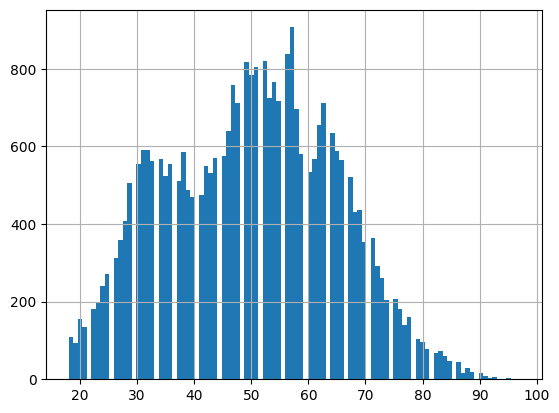

In [5]:
ALL_data['age'].hist(bins=100,label='年龄')

<AxesSubplot:>

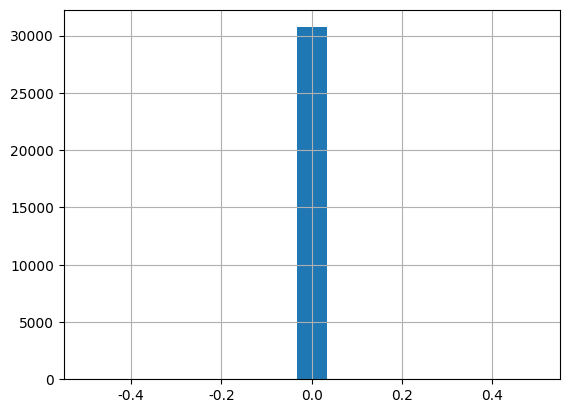

In [6]:
ALL_data['Q'].hist(bins=15)

<AxesSubplot:>

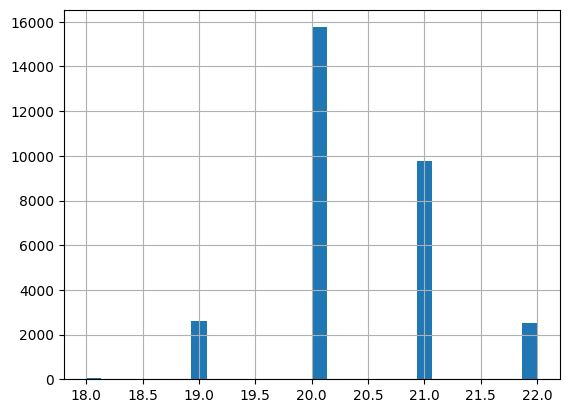

In [7]:
ALL_data['year'].hist(bins=30)

In [8]:
def is_not_digit(n):
    return not n.isdigit()
mask = ALL_data['ID'].map(is_not_digit)
filtered_data = ALL_data[mask]

In [9]:
filtered_data['ID']

Series([], Name: ID, dtype: object)